# Simple exercises with Shapely + OpenCV (may not end up using)

In [2]:
from shapely.geometry import Point, LineString, Polygon
import shapely
import numpy as np

# Create a point
p = Point(4, 5)
print("Point:", p)

# Create a line
line = LineString([(0, 0), (2, 3), (4, 5)])
geoms = np.array([Point(0, 0), Point(1, 1.5), Point(20,5)])
print(shapely.intersects(line, geoms))


print("Line length:", line.length)

# Create a polygon
polygon = Polygon([(0, 0), (4, 0), (4, 4), (0, 4)])
print("Polygon area:", polygon.area)
print("Polygon centroid:", polygon.centroid)

Point: POINT (4 5)
[ True  True False]
Line length: 6.433978400210179
Polygon area: 16.0
Polygon centroid: POINT (2 2)


In [3]:
import numpy as np
import cv2
from shapely.geometry import Polygon, LineString
from skimage.morphology import skeletonize

# Create a binary mask (simulated epithelium region)
mask = np.zeros((100, 100), dtype=np.uint8)
#it goes top left to bottom right and 255 is white (ROI) while zero is black (background) 
cv2.rectangle(mask, (20, 20), (80, 80), 255, -1)  # Simulated epithelium region

# Skeletonize the mask (find the centerline)
binary_mask = (mask > 0).astype(np.uint8)  # Ensure binary (0 or 1)
print("binary_mask", binary_mask)
#print with label 
skeleton = skeletonize(binary_mask)
print("skeleton", skeleton)
#print space before next output
print()
# Extract skeleton coordinates
skeleton_coords = np.column_stack(np.where(skeleton > 0))
print("skeleton_coords")
print(skeleton_coords)
print(skeleton_coords.shape)
print()
#it iterates through the skeleton_coords which are lists, then it splices the list starting from the end and then it converts it to a tuple
centerline = LineString([tuple(coord[::-1]) for coord in skeleton_coords])
print(centerline)
print("Centerline Length:", centerline.length)


binary_mask [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
skeleton [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]

skeleton_coords
[[49 50]
 [49 51]
 [50 49]]
(3, 2)

LINESTRING (50 49, 51 49, 49 50)
Centerline Length: 3.23606797749979


In [3]:
import pyvips as vips
print(vips.version(0))


8


# Loading the Data + getting areas

In [4]:
import slideflow as sf
import matplotlib.pyplot as plt

# Load the Whole Slide Image (WSI) & ROIs
path = "/Users/sheeltanna/Cancer_Project_2025/Cancer_Project_2025/AG037F.svs"  # Adjust if needed
wsi = sf.WSI(path, 256, 128, rois='/Users/sheeltanna/Cancer_Project_2025/Cancer_Project_2025/AG037F.csv')


# Extract polygons
rois = [roi.poly for roi in wsi.rois]  # List of Shapely Polygon objects

# # Print areas of each ROI
for i, poly in enumerate(rois):
    print(f"ROI {i+1} Area: {poly.area}")


ROI 1 Area: 9253181.0
ROI 2 Area: 26920013.0
ROI 3 Area: 18724657.5
ROI 4 Area: 17691922.5
ROI 5 Area: 12163129.5
ROI 6 Area: 9701082.0
ROI 7 Area: 2502597.5
ROI 8 Area: 1775078.5
ROI 9 Area: 9879624.5
ROI 10 Area: 6565540.0
ROI 11 Area: 3941817.5
ROI 12 Area: 9916.0


In [4]:
#alternative method for loading the data
import pandas as pd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

# Load the CSV file
csv_path = "AG037F.csv"
df = pd.read_csv(csv_path)

# Group points by ROI name
roi_polygons = {}
#note that groupby is grouping by the roi_name column
#note that group is just a subset of the dataframe corresponding to the roi_name
for roi_name, group in df.groupby("roi_name"):
    #taking the two series of x and y coordinates and zipping them together. Zip needs two interables and makes tuples
    points = list(zip(group["x_base"], group["y_base"]))  # Convert to (x, y) coordinates
    #adding to the dictionary
    roi_polygons[roi_name] = Polygon(points)  # Create Shapely Polygon

#pritning dictionary here
for roi, poly in roi_polygons.items():
    print(f"ROI {roi}: Area = {poly.area}, Length = {poly.length}")


ROI ROI_1: Area = 2502597.5, Length = 8623.268285663553
ROI ROI_11: Area = 9879624.5, Length = 20163.19792633279
ROI ROI_12: Area = 3941817.5, Length = 11004.80563576758
ROI ROI_13: Area = 6565540.0, Length = 19588.338142361168
ROI ROI_15: Area = 9916.0, Length = 582.7230085110544
ROI ROI_19: Area = 26920015.380076278, Length = 56012.26676270695
ROI ROI_20: Area = 17691922.5, Length = 40760.771033223624
ROI ROI_21: Area = 12163178.849726776, Length = 32331.874440477695
ROI ROI_3: Area = 1775078.5, Length = 5639.798155264295
ROI ROI_4: Area = 9701082.0, Length = 17040.48556076896
ROI ROI_6: Area = 9253181.0, Length = 11814.963681904235
ROI ROI_7: Area = 18724605.413780596, Length = 45251.76238768894


# Simple midpoint method
To get the centerline through the ROI which represent the epithelium region. 
Plotting midpoints shows method isn't finding entire line and some parallel lines running in wrong direction giving points in odd locations

True Centerline Length: 236.56628905408758


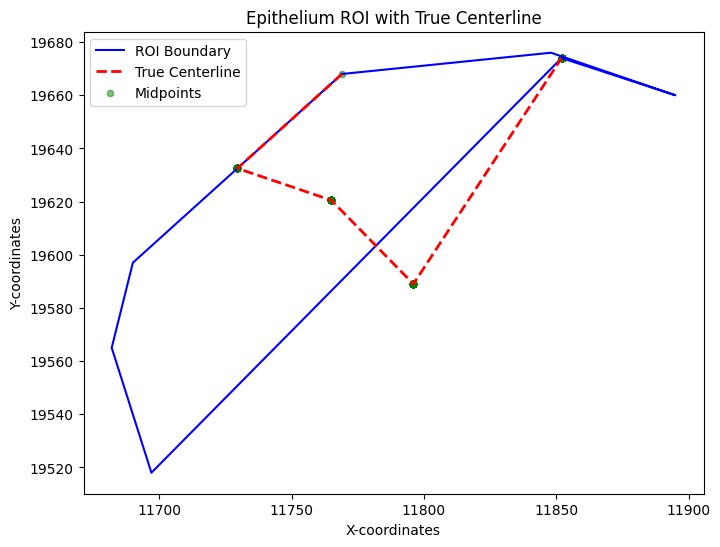

In [7]:
#getting centerline with simple method + visualizing it
from shapely.geometry import Polygon, LineString, MultiLineString
from shapely.ops import unary_union
import numpy as np
import matplotlib.pyplot as plt

# Select an example ROI polygon
roi_polygon = roi_polygons["ROI_15"]  # Replace with different ROI if needed

# Step 1: Get equally spaced points along the exterior
num_points = 1000  # Adjust for more precision
exterior_coords = np.array(roi_polygon.exterior.coords)
indices = np.linspace(0, len(exterior_coords) - 1, num_points, dtype=int)
sampled_points = exterior_coords[indices]

# Step 2: Find midpoints between opposite points on the boundary
midpoints = []
for i in range(len(sampled_points) // 2):
    x_mid = (sampled_points[i][0] + sampled_points[-(i + 1)][0]) / 2
    y_mid = (sampled_points[i][1] + sampled_points[-(i + 1)][1]) / 2
    midpoints.append((x_mid, y_mid))

# Step 3: Convert midpoints into a LineString
centerline = LineString(midpoints)

# Step 4: Measure the centerline length
print("True Centerline Length:", centerline.length)

# Step 5: Visualize ROI boundary and the extracted centerline
fig, ax = plt.subplots(figsize=(8, 6))

# Plot ROI boundary
x, y = roi_polygon.exterior.xy
ax.plot(x, y, linestyle="-", color="blue", label="ROI Boundary")

# Plot Centerline
x_c, y_c = centerline.xy
ax.plot(x_c, y_c, linestyle="--", color="red", linewidth=2, label="True Centerline")

# Plot midpoints
midpoints_array = np.array(midpoints)
ax.scatter(midpoints_array[:,0], midpoints_array[:,1], color='green', s=20, alpha=0.5, label='Midpoints')

plt.xlabel("X-coordinates")
plt.ylabel("Y-coordinates")
plt.title("Epithelium ROI with True Centerline")
plt.legend()
plt.show()


# Visualizing voronoi method


Divides plane into seperate reegions. Each region has one seed and eery point in the region is closer to that seed than any other seed. 


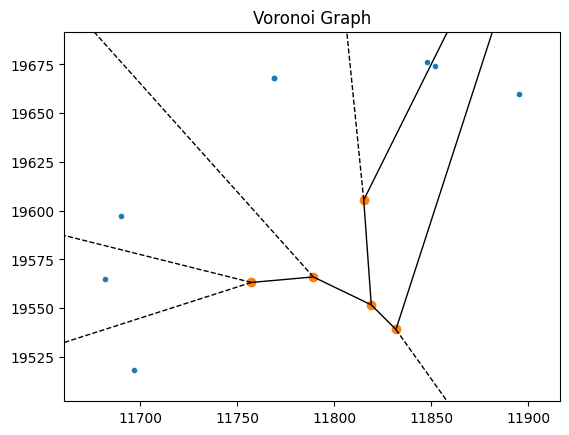

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, MultiLineString, Point
from shapely.ops import unary_union
from scipy.spatial import Voronoi, voronoi_plot_2d

# Select an example ROI polygon
roi_polygon = roi_polygons["ROI_15"]  # Replace with different ROI if needed

# Extract boundary points from the polygon
boundary_coords = np.array(roi_polygon.exterior.coords)

# Compute Voronoi diagram from boundary points
vor = Voronoi(boundary_coords)
fig = voronoi_plot_2d(vor)
plt.title("Voronoi Graph")
plt.show()

#get the vertices that define the regions
vor_vertices = vor.vertices


# Running Vornoi method (limited filtering)

Not terrible but lots of branching!! 
Tested multiple ROIs and the centerline always present but still lots of branching --> need to smooth

vertices = coords where 3 or more voronoi regions meet
Ridge_vertices = pairs of indces that refers to the vertices and represents a line segment between two vertices (-1 means infinite)
vor.vertices = 2-d array of coordinates of the voronoi vertices
vor.ridge_vertices = list of tuples, each tuple contains the indices of the vertices that form a line segment in the voronoi diagram

EX: if vpair = [0,1] this means an edge is between vertex 0 and vertex 1. You can find the actual coordinates of vertex 0 by using vor.vertices[vpair[0]], which gives the first row which represents the coordinates of vertex 0. 

Overall, uses the edges and filters ones that extend to infinity. Gets the actual vertices, generates lines, and then filters lines not inside of the polygon. This still leaves branches, which are lines that are contained within the polygon. Additional filtering could be in the form of graph based approach, angle, centroid calculations, etc. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, MultiLineString, Point
from shapely.ops import unary_union
from scipy.spatial import Voronoi, voronoi_plot_2d

# Select an example ROI polygon
roi_polygon = roi_polygons["ROI_15"]  # Replace with different ROI if needed

# Step 1: Extract boundary points from the polygon
boundary_coords = np.array(roi_polygon.exterior.coords)
# Step 2: Compute Voronoi diagram from boundary points
vor = Voronoi(boundary_coords)

# Step 3: Extract Voronoi edges and filter only those inside the polygon
valid_lines = []
for vpair in vor.ridge_vertices:
    if -1 in vpair:  # Ignore edges that extend to infinity
        continue
    p1, p2 = vor.vertices[vpair[0]], vor.vertices[vpair[1]]
    line = LineString([p1, p2])
    
    # Keep the line only if it's fully inside the polygon
    # maybe fix becuase just becuase it contains line doens't mean it's the centerline
    if roi_polygon.contains(line):
        valid_lines.append(line)

# Step 4: Merge all valid Voronoi lines into a single MultiLineString
medial_axis = unary_union(valid_lines)

# Step 5: Compute centerline length
print("Voronoi Medial Axis Length:", medial_axis.length)

# Step 6: Plot the ROI and the extracted medial axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot ROI boundary
x, y = roi_polygon.exterior.xy
ax.plot(x, y, linestyle="-", color="blue", label="ROI Boundary")

# Plot Centerline (Medial Axis)
if isinstance(medial_axis, MultiLineString):
    for line in medial_axis.geoms:
        x_c, y_c = line.xy
        ax.plot(x_c, y_c, linestyle="--", color="red", linewidth=2)
else:
    x_c, y_c = medial_axis.xy
    ax.plot(x_c, y_c, linestyle="--", color="red", linewidth=2, label="Voronoi Centerline")

plt.xlabel("X-coordinates")
plt.ylabel("Y-coordinates")
plt.title("Epithelium ROI with Voronoi-Based Centerline")
plt.legend()
plt.show()


NameError: name 'roi_polygons' is not defined

# Vornoi with Filtering (Graph based method)
Promising results but some have branches/not complete. Overall, very good filtering achieved but sometimes too much. Choosing the start node with the highest degree seems to be a flawed method because sometimes it chooses a node in the middle of the polygon. Need alternative selection method. 

G Graph with 124 nodes and 123 edges
longest_path [(23378.982060155733, 52997.41605170746), (23474.135760188445, 52958.52489365595), (23550.366164941508, 52949.711046119926), (23552.13155877995, 52949.147907832215), (23663.183412749033, 52927.37843769932), (23712.036982775146, 52921.73234383985), (23718.816224213035, 52921.667625544505), (23825.851832769025, 52897.7358310025), (23829.789930064275, 52897.326494724504), (23905.129717783067, 52881.35923155389), (23959.84842883549, 52864.16192236599), (24043.934881310764, 52853.11624636036), (24087.71513259877, 52842.35403661653), (24187.190380291086, 52811.07326595666), (24266.14167492641, 52776.88024784209), (24373.66403064036, 52784.79942549322), (24458.5, 52777.904320987655), (24513.77896313505, 52769.37361680015), (24613.812738148892, 52732.4462551727), (24640.36532820043, 52719.63376084652), (24714.426538538806, 52699.68561575035), (24765.232222021816, 52682.110996667965), (24766.71227370958, 52681.75514518268), (24865.0, 52626.0), (

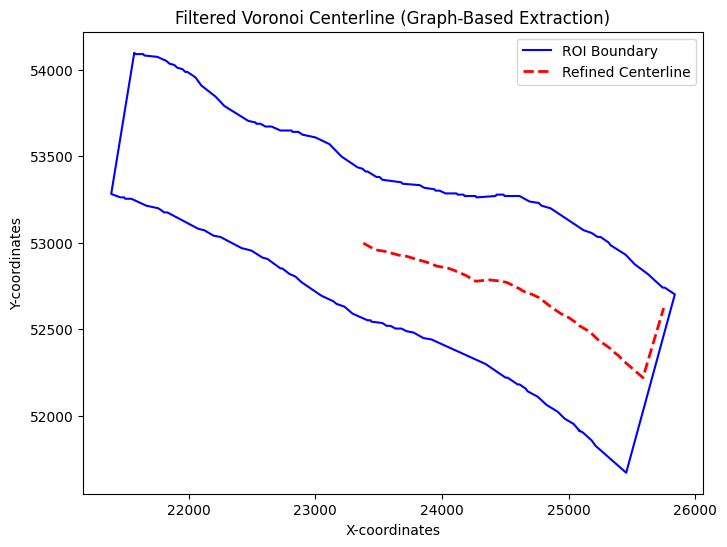

In [7]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, MultiLineString
from shapely.ops import unary_union
from scipy.spatial import Voronoi

# Select an example ROI polygon
roi_polygon = roi_polygons["ROI_12"]  # Change for different ROIs

# Step 1: Extract boundary points from the polygon
boundary_coords = np.array(roi_polygon.exterior.coords)

# Step 2: Compute Voronoi diagram from boundary points
vor = Voronoi(boundary_coords)

# Step 3: Extract Voronoi edges and filter those inside the polygon
valid_lines = []
for vpair in vor.ridge_vertices:
    if -1 in vpair:  # Ignore infinite edges
        continue
    p1, p2 = vor.vertices[vpair[0]], vor.vertices[vpair[1]]
    line = LineString([p1, p2])
    
    # Keep only lines fully inside the polygon
    if roi_polygon.contains(line):
        valid_lines.append(line)

# Merge valid lines into a single geometry
medial_axis = unary_union(valid_lines)

# Step 4: Convert Medial Axis to a Graph (For Merging Components)
def medial_axis_to_graph(medial_axis):
    """Convert medial axis lines into a NetworkX graph."""
    G = nx.Graph()
    if isinstance(medial_axis, MultiLineString):
        #remember that each line is a vornoi edge connected two vertices 
        for line in medial_axis.geoms:
            coords = list(line.coords)
            for i in range(len(coords) - 1):
                G.add_edge(coords[i], coords[i + 1], weight=line.length)
                #note that each node is a unique vertex from the vornoi diagram
    elif isinstance(medial_axis, LineString):
        coords = list(medial_axis.coords)
        for i in range(len(coords) - 1):
            G.add_edge(coords[i], coords[i + 1], weight=medial_axis.length)
    return G

# Convert to graph
G = medial_axis_to_graph(medial_axis)
print("G", G)

# Step 5: Extract the Largest Connected Component
largest_cc = max(nx.connected_components(G), key=len)  # Largest cluster
#Get rid of any branches not connected ot the main skeleton which should be largest cc. Noticed most of the time largest cc dones't do any filtering
G_largest = G.subgraph(largest_cc).copy()

# Step 6
# the Longest Path in the Largest Connected Component should be centerline (based on choice of start and end node)
if len(G_largest.nodes) > 0:
    #start node is the one with the most connections
    start_node = max(G_largest.nodes, key=lambda x: G_largest.degree[x], default=None)
    if start_node:
        # Find the farthest node from the start node
        # Iterating through all the other nodes to find the node furthest away. Longest path most likely the centerline while ignoring 
        # branches still present in the largest cc subgraph. 
        end_node = max(G_largest.nodes, key=lambda x: nx.shortest_path_length(G_largest, start_node, x), default=None)
        if end_node:
            #returns a list of nodes which are (x,y) coordinates that represent a vornoi vertex
            longest_path = nx.shortest_path(G_largest, source=start_node, target=end_node)
            print("longest_path", longest_path)
            centerline = LineString(longest_path)
        else:
            print("No valid endpoint found.")
    else:
        print("No valid start node found.")
else:
    print("Graph is empty after filtering.")


# Convert path back to LineString
centerline = LineString(longest_path)

# Step 7: Compute and Print Centerline Length
print("Refined Centerline Length:", centerline.length)

# Step 8: Plot the ROI and the extracted centerline
fig, ax = plt.subplots(figsize=(8, 6))

# Plot ROI boundary
x, y = roi_polygon.exterior.xy
ax.plot(x, y, linestyle="-", color="blue", label="ROI Boundary")

# Plot Centerline
x_c, y_c = centerline.xy
ax.plot(x_c, y_c, linestyle="--", color="red", linewidth=2, label="Refined Centerline")

plt.xlabel("X-coordinates")
plt.ylabel("Y-coordinates")
plt.title("Filtered Voronoi Centerline (Graph-Based Extraction)")
plt.legend()
plt.show()


# Graph based with additional changes

Tried percetile based trimming and it works really well! Before ends of the graph based method were not representative of the centerline. Trimming seems to be a simpler solution rather than filtering based on width, angle, etc. 10% seems to be a good threshold. 

[ROI_11] Centerline Length (after percentile trim): 8105.475831093113


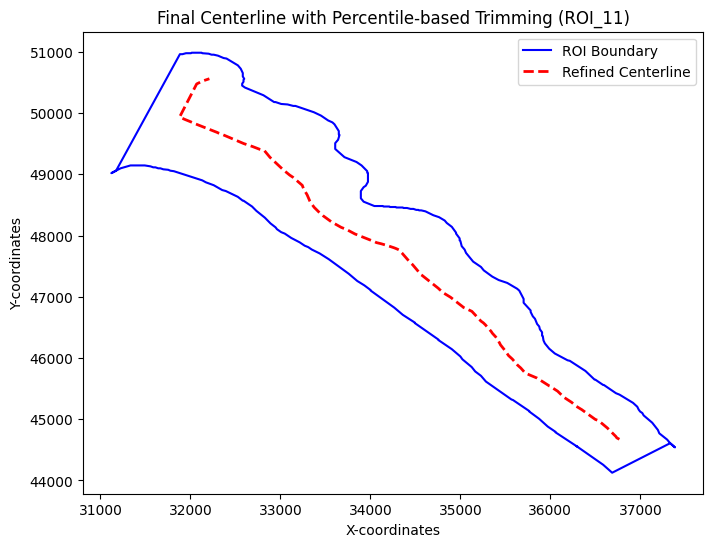

In [10]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, MultiLineString, Point
from shapely.ops import unary_union
from scipy.spatial import Voronoi

# --------------------------
# 1) Percentile-based Trim
# --------------------------
def trim_ends_by_percentile(centerline, polygon, low_pct=10):
    """
    Trims centerline points whose distance to polygon boundary
    is below the `low_pct` percentile of all distances.
    This automatically adapts to different ROI shapes & sizes.
    """
    if not centerline or not len(centerline.coords):
        return None

    coords = list(centerline.coords)

    # 1. Compute distance to boundary for all points
    #same size as the coords list and first entry here corresponds to the distance of the first point in coords to the boundary, etc. 
    #This allows us to zip the two lists together and then filter based on the distance later on
    dists = [polygon.exterior.distance(Point(pt)) for pt in coords]

    # 2. Determine cutoff using low percentile
    # so if it's 10 it means cutoff is 10th percentile of distances 
    # (idea is that the points with the smallest distances to boundary are the "tails" we noticed that aren't part of the true centerline )
    cutoff = np.percentile(dists, low_pct)

    # 3. Keep only points with distance >= cutoff
    new_coords = [pt for pt, dist in zip(coords, dists) if dist >= cutoff]

    # 4. Rebuild centerline
    if len(new_coords) < 2:
        return None
    return LineString(new_coords)

# --------------------------
# 2) Your Existing Voronoi + Graph Steps
# --------------------------

# Convert to graph
def medial_axis_to_graph(medial_axis):
    G = nx.Graph()
    if isinstance(medial_axis, MultiLineString):
        for line in medial_axis.geoms:
            coords = list(line.coords)
            for i in range(len(coords) - 1):
                #the weight is the distance between the two points
                seg_length = Point(coords[i]).distance(Point(coords[i+1]))
                G.add_edge(coords[i], coords[i+1], weight=seg_length)
    elif isinstance(medial_axis, LineString):
        coords = list(medial_axis.coords)
        for i in range(len(coords) - 1):
            seg_length = Point(coords[i]).distance(Point(coords[i+1]))
            G.add_edge(coords[i], coords[i+1], weight=seg_length)
    return G
def find_longest_path(G_largest):
    #iterating through all nodes and keeping the ones with degree 1 (terminal nodes)
    terminal_nodes = [n for n in G_largest.nodes if G_largest.degree[n] == 1]
    if len(terminal_nodes) < 2:
        return None

    max_length = 0
    best_pair = None
    #double loop tof find distance between each pair of terminal nodes
    #two terminal nodes that are furthest apart should represent the centerline
    for i in range(len(terminal_nodes)):
        for j in range(i+1, len(terminal_nodes)):
            try:
                path_length = nx.shortest_path_length(
                    G_largest, terminal_nodes[i], terminal_nodes[j], weight="weight"
                )
                if path_length > max_length:
                    max_length = path_length
                    #update best pair to this one with the longest distance
                    best_pair = (terminal_nodes[i], terminal_nodes[j])
            except nx.NetworkXNoPath:
                pass

    if not best_pair:
        return None
    #returns the longest path between the two terminal nodes
    return nx.shortest_path(G_largest, source=best_pair[0], target=best_pair[1], weight="weight")

# For example, choose an ROI to process
roi_name = "ROI_11"
roi_polygon = roi_polygons[roi_name]

# Extract boundary points
boundary_coords = np.array(roi_polygon.exterior.coords)

# Compute Voronoi
vor = Voronoi(boundary_coords)

# Filter Voronoi edges inside the polygon
valid_lines = []
for vpair in vor.ridge_vertices:
    if -1 in vpair:  
        continue
    p1, p2 = vor.vertices[vpair[0]], vor.vertices[vpair[1]]
    line = LineString([p1, p2])
    if roi_polygon.contains(line):
        valid_lines.append(line)

# Merge edges into a single geometry
medial_axis = unary_union(valid_lines)
G = medial_axis_to_graph(medial_axis)

# Largest connected component
largest_cc = max(nx.connected_components(G), key=len)
G_largest = G.subgraph(largest_cc).copy()

# Find the longest path among terminal nodes

longest_path = find_longest_path(G_largest)
if longest_path:
    centerline = LineString(longest_path)
else:
    centerline = None

# --------------------------
# 3) Apply Percentile-based Trim
# --------------------------
#centerline is longest path but may have tails--->trim the line to get the true centerline
if centerline:
    # e.g., low_pct=10 means removing points in the lower 10% boundary distance
    centerline = trim_ends_by_percentile(centerline, roi_polygon, low_pct=10)

# --------------------------
# 4) Visualization
# --------------------------
if centerline and len(centerline.coords) > 1:
    print(f"[{roi_name}] Centerline Length (after percentile trim):", centerline.length)

fig, ax = plt.subplots(figsize=(8, 6))
x, y = roi_polygon.exterior.xy
ax.plot(x, y, linestyle="-", color="blue", label="ROI Boundary")

if centerline and len(centerline.coords) > 1:
    cx, cy = centerline.xy
    ax.plot(cx, cy, linestyle="--", color="red", linewidth=2, label="Refined Centerline")

plt.xlabel("X-coordinates")
plt.ylabel("Y-coordinates")
plt.title(f"Final Centerline with Percentile-based Trimming ({roi_name})")
plt.legend()
plt.show()


In [11]:
# get list of unique ROIs 
roi_names = df['roi_name'].unique()
roi_polygons_list = [] 

# get the roi_polygons 
for roi in roi_names: 
    roi_polygons_list.append((roi, roi_polygons[roi]))

[ROI_11] Centerline Length (after percentile trim): 8105.475831093113


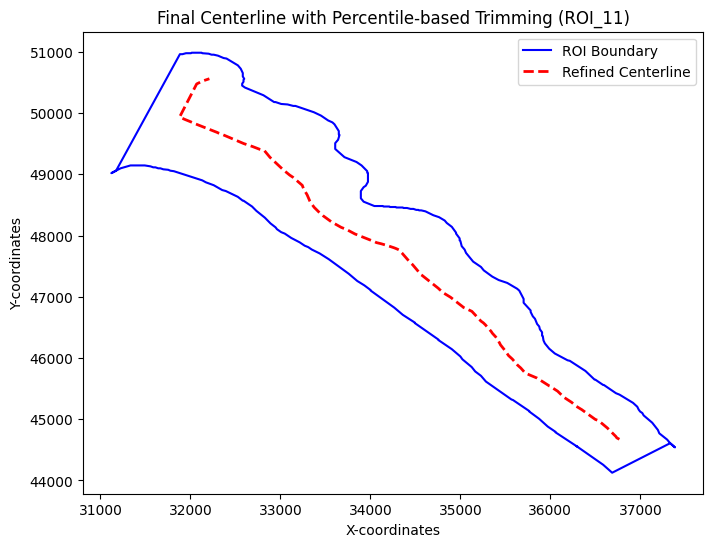

[ROI_13] Centerline Length (after percentile trim): 8195.754318899917


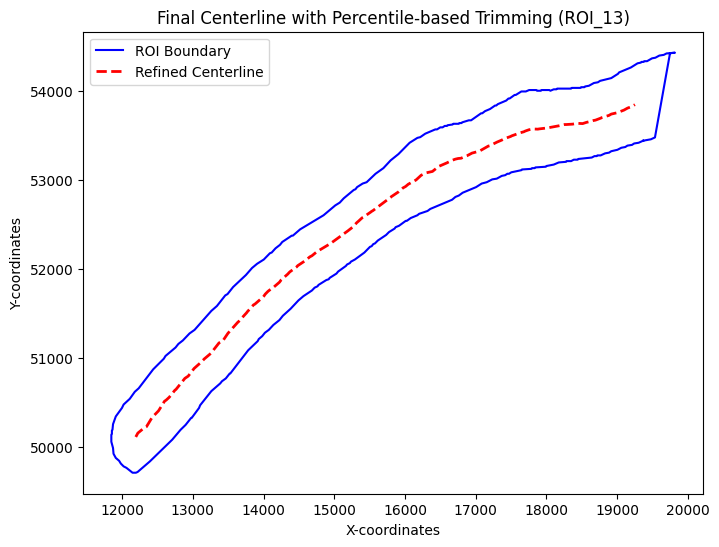

[ROI_12] Centerline Length (after percentile trim): 3930.312938551824


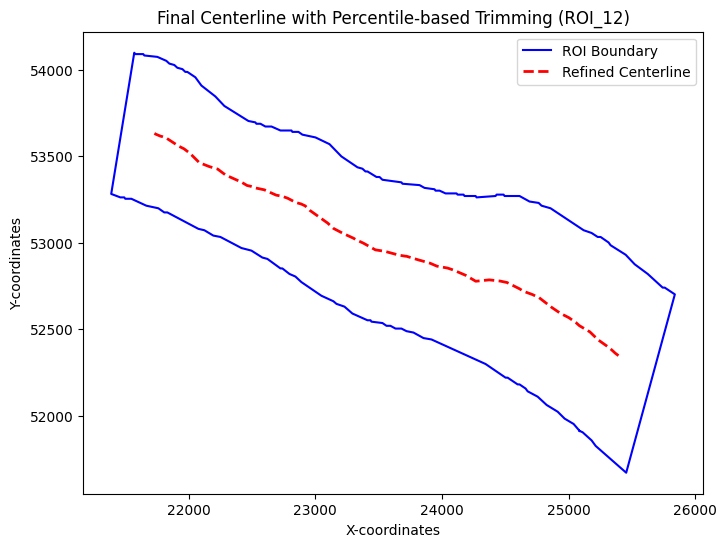

Skipping ROI_15: No valid medial axis.
[ROI_6] Centerline Length (after percentile trim): 3979.388650879347


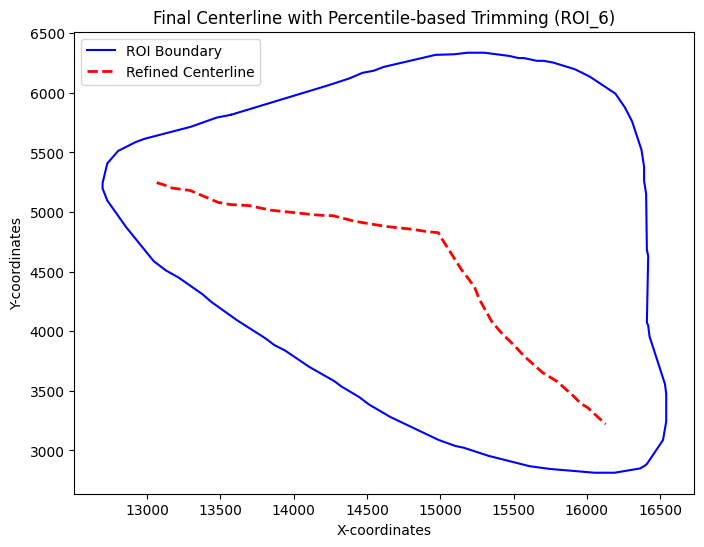

[ROI_19] Centerline Length (after percentile trim): 25305.516852718047


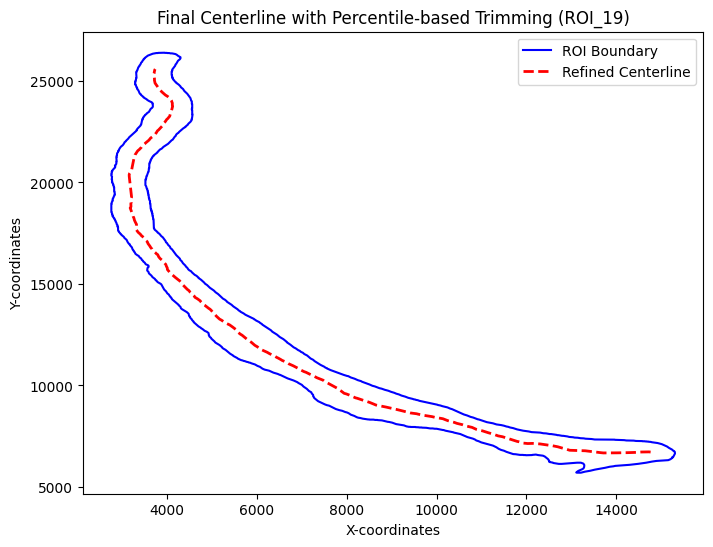

[ROI_7] Centerline Length (after percentile trim): 20297.635220006145


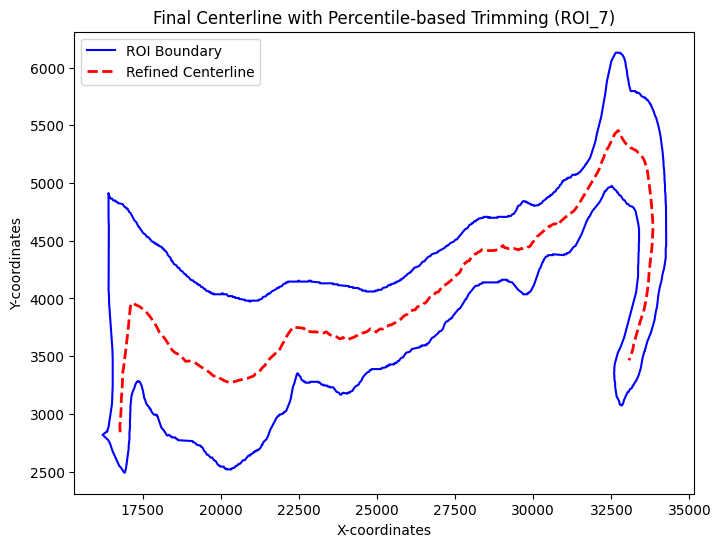

[ROI_20] Centerline Length (after percentile trim): 18785.027904954706


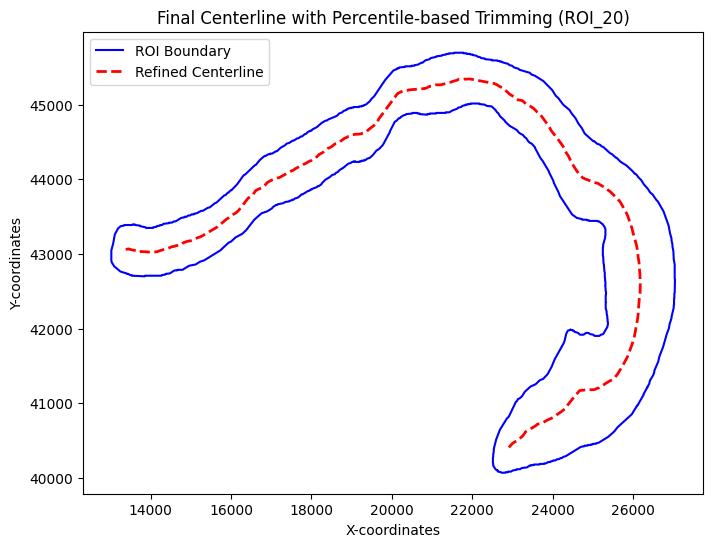

[ROI_21] Centerline Length (after percentile trim): 14166.444585346018


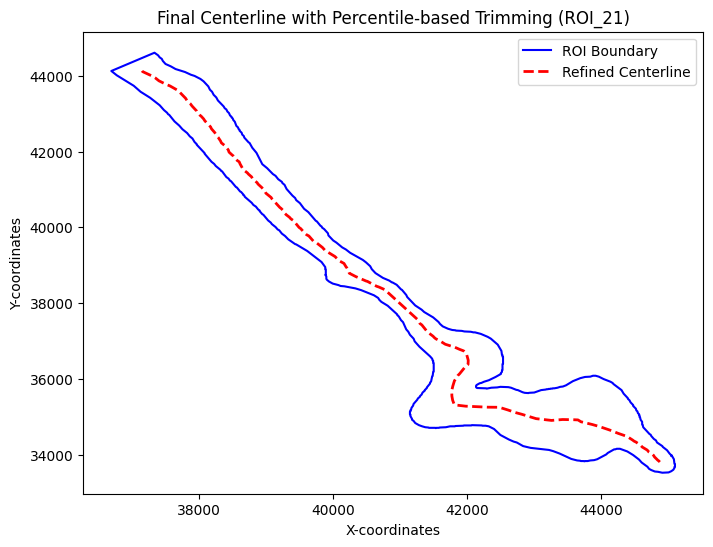

[ROI_4] Centerline Length (after percentile trim): 5293.640128205768


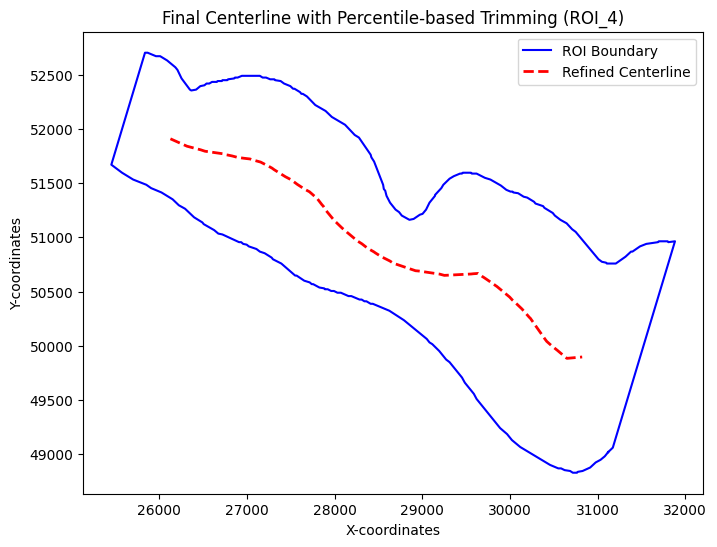

[ROI_1] Centerline Length (after percentile trim): 3308.5266910093897


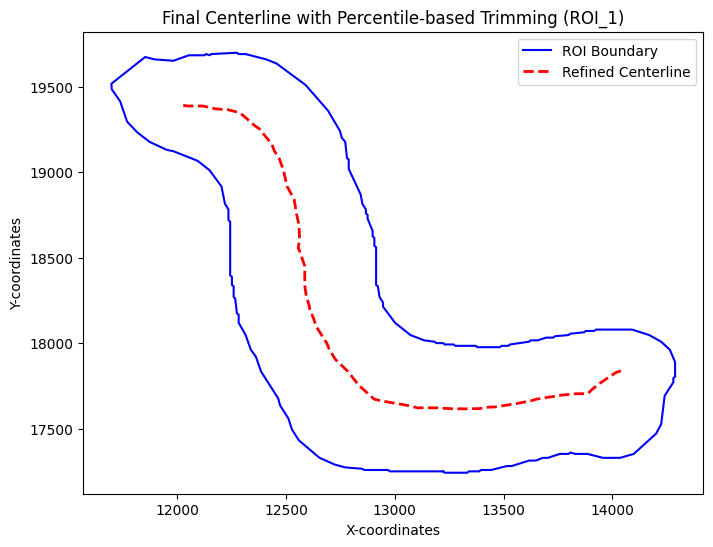

[ROI_3] Centerline Length (after percentile trim): 1546.0206738416578


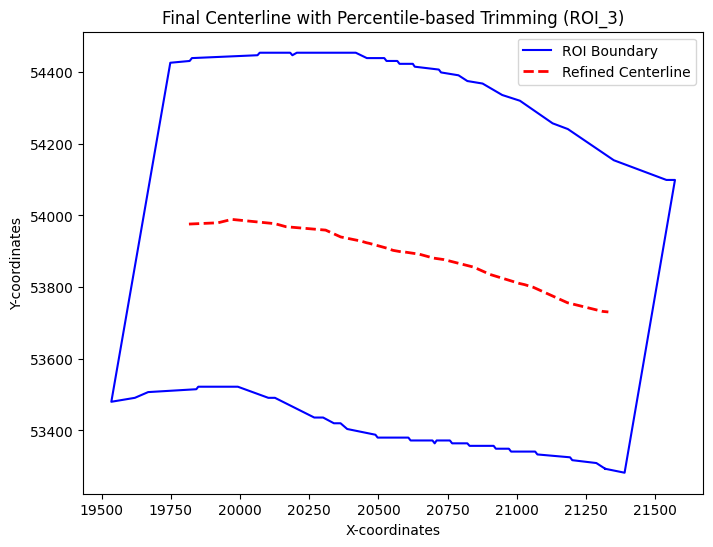

In [15]:
for roi, roi_polygon in roi_polygons_list:
    # Extract boundary points
    boundary_coords = np.array(roi_polygon.exterior.coords)
    # Compute Voronoi
    vor = Voronoi(boundary_coords)
    # Filter Voronoi edges inside the polygon
    valid_lines = []
    for vpair in vor.ridge_vertices:
        if -1 in vpair:  
            continue
        p1, p2 = vor.vertices[vpair[0]], vor.vertices[vpair[1]]
        line = LineString([p1, p2])
        if roi_polygon.contains(line):
            valid_lines.append(line)

    # Merge edges into a single geometry
    medial_axis = unary_union(valid_lines)
    # skip the medial axis is empty 
    if medial_axis.is_empty: 
        print(f"Skipping {roi}: No valid medial axis.")
        continue
    G = medial_axis_to_graph(medial_axis)
    # Largest connected component
    largest_cc = max(nx.connected_components(G), key=len)
    G_largest = G.subgraph(largest_cc).copy()
    # find the longest path among terminal nodes
    longest_path = find_longest_path(G_largest)
    if longest_path:
        centerline = LineString(longest_path)
    else:
        centerline = None
    
    if centerline:
    # e.g., low_pct=10 means removing points in the lower 10% boundary distance
        centerline = trim_ends_by_percentile(centerline, roi_polygon, low_pct=10)

    # visualization 
    if centerline and len(centerline.coords) > 1:
        print(f"[{roi}] Centerline Length (after percentile trim):", centerline.length)

    fig, ax = plt.subplots(figsize=(8, 6))
    x, y = roi_polygon.exterior.xy
    ax.plot(x, y, linestyle="-", color="blue", label="ROI Boundary")

    if centerline and len(centerline.coords) > 1:
        cx, cy = centerline.xy
        ax.plot(cx, cy, linestyle="--", color="red", linewidth=2, label="Refined Centerline")

    plt.xlabel("X-coordinates")
    plt.ylabel("Y-coordinates")
    plt.title(f"Final Centerline with Percentile-based Trimming ({roi})")
    plt.legend()
    plt.show()

### Quantiative Analysis for Grayson

In [ ]:
import csv 
import pandas as pd

In [ ]:
df = pd.read_csv('tracking.csv')